In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Getting Started

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [75]:
from sklearn.utils.fixes import sklearn
print(tf.__version__)
print(tf.keras.__version__)
print(np.__version__)
print(pd.__version__)

print(sklearn.__version__)

2.9.2
2.9.0
1.21.6
1.3.5
1.0.2


In [56]:
# Turn the directory paths into Path object
train_dir_pos = Path('/content/drive/MyDrive/Datasets/Projects/Bridge_Cracks_Detection/train/Positive')
train_dir_neg = Path('/content/drive/MyDrive/Datasets/Projects/Bridge_Cracks_Detection/train/Negative')

test_dir_pos = Path('/content/drive/MyDrive/Datasets/Projects/Bridge_Cracks_Detection/test/Positive')
test_dir_neg = Path('/content/drive/MyDrive/Datasets/Projects/Bridge_Cracks_Detection/test/Negative')

valid_dir_pos = Path('/content/drive/MyDrive/Datasets/Projects/Bridge_Cracks_Detection/valid/Positive')
valid_dir_neg = Path('/content/drive/MyDrive/Datasets/Projects/Bridge_Cracks_Detection/valid/Negative')

# Create DataFrame

Let's create a DataFrame containing the path of the image and the associated label. This will permit to flow the images from it.

In [57]:
def generate_df(image_dir, label):
    """
    Create the DataFrame of the associated directory and label.
    """
    
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    
    return df

In [58]:
# Check Train DataFrame
positive_df_train = generate_df(train_dir_pos, 'POSITIVE')
negative_df_train = generate_df(train_dir_neg, 'NEGATIVE')

# Concatenate DataFrame (on top of each other)
data_train = pd.concat([positive_df, negative_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
data_train.head()

,Filepath,Label
0,/content/drive/MyDrive/Datasets/Projects/Bridg...,POSITIVE
1,/content/drive/MyDrive/Datasets/Projects/Bridg...,NEGATIVE
2,/content/drive/MyDrive/Datasets/Projects/Bridg...,NEGATIVE
3,/content/drive/MyDrive/Datasets/Projects/Bridg...,POSITIVE
4,/content/drive/MyDrive/Datasets/Projects/Bridg...,POSITIVE


In [59]:
# Check Test DataFrame
positive_df_test = generate_df(test_dir_pos, 'POSITIVE')
negative_df_test = generate_df(test_dir_neg, 'NEGATIVE')


# Concatenate DataFrame (on top of each other)
data_test = pd.concat([positive_df_test, negative_df_test], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
data_test.head()

,Filepath,Label
0,/content/drive/MyDrive/Datasets/Projects/Bridg...,POSITIVE
1,/content/drive/MyDrive/Datasets/Projects/Bridg...,POSITIVE
2,/content/drive/MyDrive/Datasets/Projects/Bridg...,POSITIVE
3,/content/drive/MyDrive/Datasets/Projects/Bridg...,NEGATIVE
4,/content/drive/MyDrive/Datasets/Projects/Bridg...,NEGATIVE


In [60]:
# Check Valid DataFrame
positive_df_valid = generate_df(valid_dir_pos, 'POSITIVE')
negative_df_valid = generate_df(valid_dir_neg, 'NEGATIVE')


# Concatenate DataFrame (on top of each other)
data_valid = pd.concat([positive_df_valid, negative_df_valid], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
data_valid.head()

,Filepath,Label
0,/content/drive/MyDrive/Datasets/Projects/Bridg...,POSITIVE
1,/content/drive/MyDrive/Datasets/Projects/Bridg...,POSITIVE
2,/content/drive/MyDrive/Datasets/Projects/Bridg...,POSITIVE
3,/content/drive/MyDrive/Datasets/Projects/Bridg...,NEGATIVE
4,/content/drive/MyDrive/Datasets/Projects/Bridg...,NEGATIVE


# Loading Image Data

In [61]:
# Image generator for the training set
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

# Image generator for the test set
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)


In [62]:
# Generate training images
train_images = train_generator.flow_from_dataframe(
    data_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
)

# Generate validation images
val_images = test_generator.flow_from_dataframe(
    data_valid,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
)

# Generate test images
test_images = test_generator.flow_from_dataframe(
    data_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 600 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


# Training

In [63]:
# Create the layers
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)


x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)


x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)


outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [64]:
# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 59, 59, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d_2   (None, 32)               0   

In [65]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [66]:
# History
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
19/19 [==============================] - 3s 122ms/step - loss: 0.6943 - accuracy: 0.4967 - val_loss: 0.6906 - val_accuracy: 0.7200
Epoch 2/100
19/19 [==============================] - 2s 110ms/step - loss: 0.6901 - accuracy: 0.5300 - val_loss: 0.6853 - val_accuracy: 0.5000
Epoch 3/100
19/19 [==============================] - 2s 111ms/step - loss: 0.6858 - accuracy: 0.5733 - val_loss: 0.6764 - val_accuracy: 0.7850
Epoch 4/100
19/19 [==============================] - 2s 110ms/step - loss: 0.6749 - accuracy: 0.6233 - val_loss: 0.6675 - val_accuracy: 0.5000
Epoch 5/100
19/19 [==============================] - 3s 137ms/step - loss: 0.6499 - accuracy: 0.6117 - val_loss: 0.6123 - val_accuracy: 0.7000
Epoch 6/100
19/19 [==============================] - 2s 113ms/step - loss: 0.5914 - accuracy: 0.7583 - val_loss: 0.4724 - val_accuracy: 0.8200
Epoch 7/100
19/19 [==============================] - 2s 110ms/step - loss: 0.4805 - accuracy: 0.7967 - val_loss: 0.3696 - val_accuracy: 0.9400

In [67]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epochs", 'value':"Loss"},
    title=("Training and Validation Loss over Time")
)

fig.show()

# Results

In [68]:
y_pred = (model.predict(test_images).squeeze() >= 0.5).astype(int)

def evaluate_model(model):
    
    results = model.evaluate(test_images, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("Test Loss: {:.5f}".format(loss))
    print("Accuracy: {:.2f}%".format(acc * 100))
    
    cm = confusion_matrix(test_images.labels, y_pred)
    clr = classification_report(test_images.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print("Classification Report:\n------------------------------\n", clr)

7/7 [==============================] - 1s 63ms/step


Test Loss: 0.56090
Accuracy: 77.50%


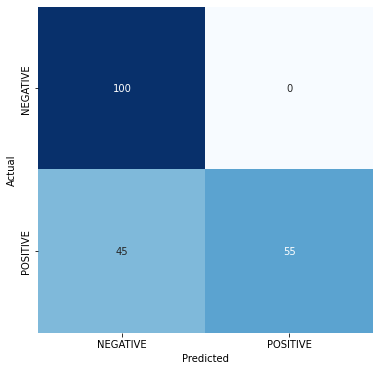

Classification Report:
------------------------------
               precision    recall  f1-score   support

    NEGATIVE       0.69      1.00      0.82       100
    POSITIVE       1.00      0.55      0.71       100

    accuracy                           0.78       200
   macro avg       0.84      0.78      0.76       200
weighted avg       0.84      0.78      0.76       200



In [69]:
evaluate_model(model)